# Importing Relevant Libraries and Initialization

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.pylab as pylab
import seaborn as sns
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings('ignore')

# default parameters
pylab.rcParams['figure.figsize'] = (15, 8)

# Auxiliary Functions 

In [2]:
def sliding_window(ts, target=[], lags=5):
    """ Split the time series in windows according to the number of lags defined.
    
    Parameters
    ----------
    ts: array-like (N_samples, 1)
        univariate time series to which the sliding window is applied.
    
    target: array-like (N_samples, 1), default = []
        target variable.
    
    lags: int, default = 5
        number of lags used in the sliding window.
        
    Returns
    -------
    X: array (N_samples - lags, lags)
    
    y: array (N_samples - lags,)
    """
    X = []
    y = []
    
    for i in range(len(ts)-lags):
        X.append(ts[i:i+lags])
        if len(target) > 0:
            y.append(target[i+lags])
        else:
            y.append(ts[i+lags])
    
    return np.array(X), np.array(y)

# Reading the Data 

In [3]:
df = pd.read_csv("../data/CHRIS-LIFFE_C1.csv", index_col=0)
df.index = df.index.astype('datetime64[ns]') # index for our time series
df.sort_index(inplace=True) # sort in ascending date order to ease the data manipulation
settle_series = df["Settle"].dropna() # for easy data manipulation

Now create a new feature for the price variation. 1 when the settle price variation bewteen two consecutive days is positive and 0, when it is negative.

In [6]:
df["Settle Direction Var."] = np.where(df["Settle"] >= df["Settle"].shift(), 1, 0)

# Visualizations 

## Visualizing the Settle Price

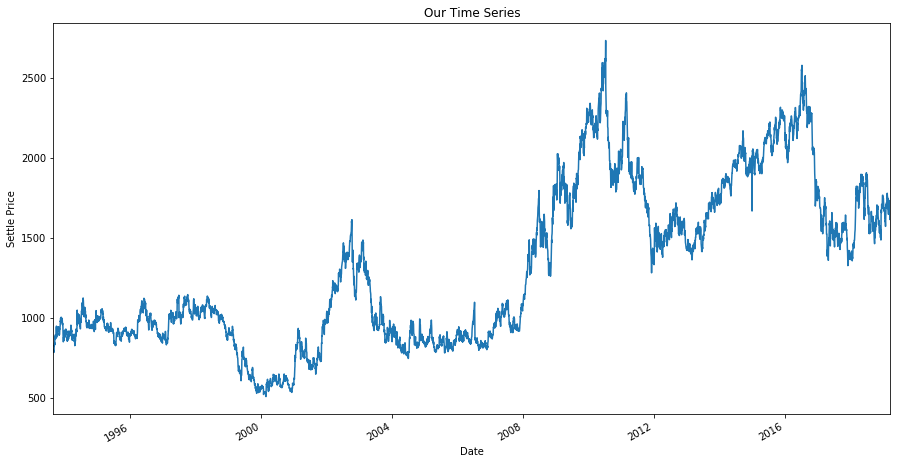

In [6]:
plt.title("Our Time Series")
df["Settle"].plot()
plt.ylabel("Settle Price");

##  Visualizing the Settle Price Variation Direction

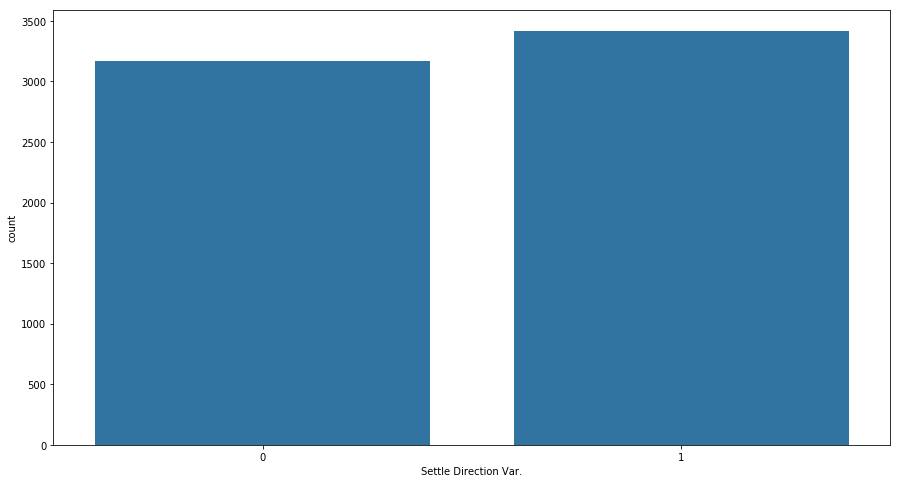

In [8]:
sns.countplot(x="Settle Direction Var.", data=df, color="C0");

## First Order Difference

In [23]:
first_difference = settle_series - settle_series.shift()
first_difference.dropna(inplace=True)

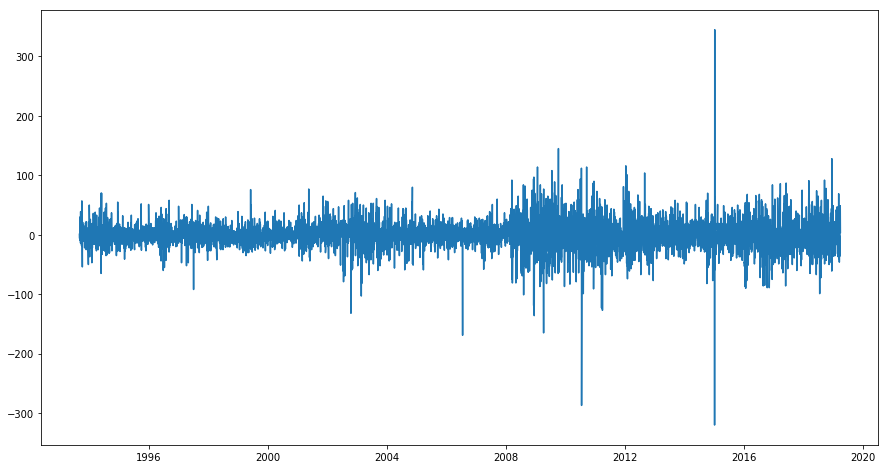

In [25]:
plt.plot(first_difference);

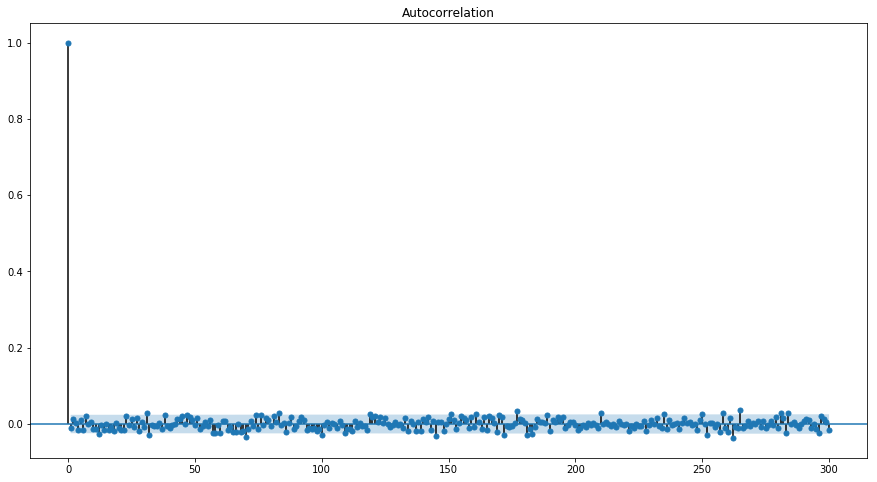

In [51]:
plot_acf(first_difference, lags=300);

## Squared Mean-adjusted Values 

We check now the line plot and the correlogram of the squared mean-adjusted values to inspect if the series preesent periods of volatility, that means, periods of increased variability.

In [31]:
squared_values = (first_difference - first_difference.mean())**2

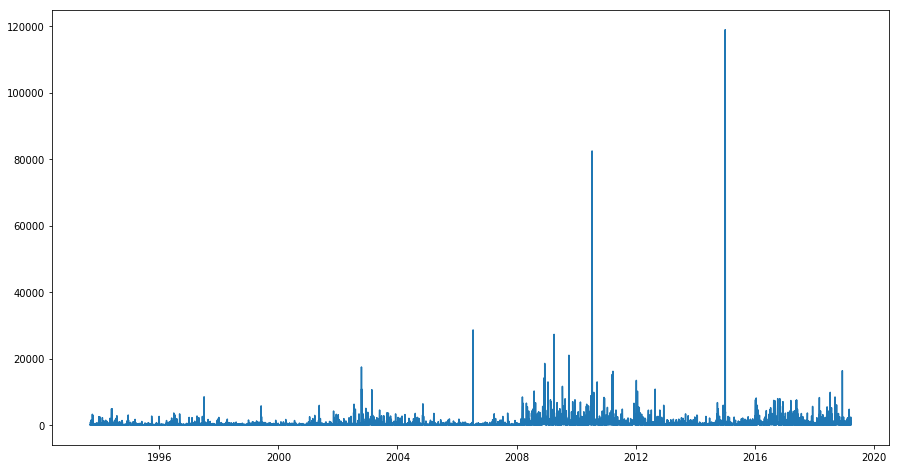

In [34]:
plt.plot(squared_values)

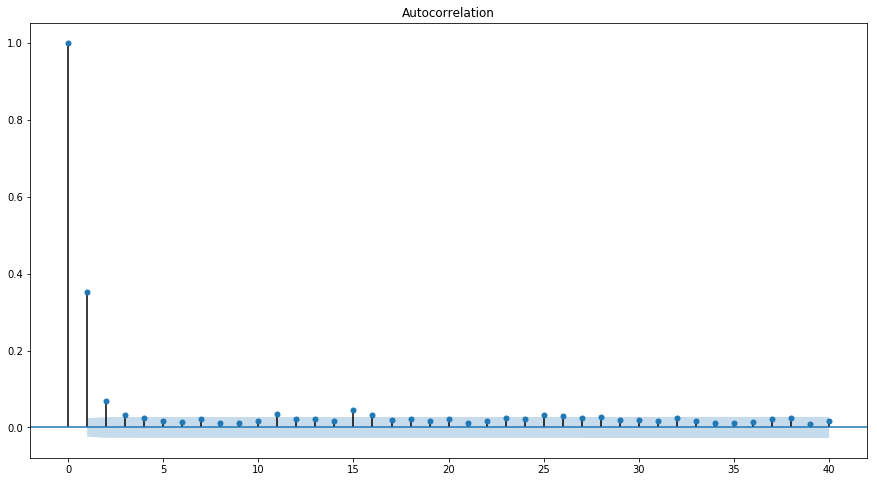

In [41]:
plot_acf(squared_values, lags=40);

# Train and Test Data Splits 

In [10]:
# split into training and testing data
split_factor = 0.7
train_max_idx = int(len(settle_series)*split_factor)
train_data = settle_series[:train_max_idx]
test_data = settle_series[train_max_idx:]

# Naive Forecast 

The Naive Forecast model simply predict for the next time point the same value as the current time point.

In [332]:
# check the fit in the train data
train_predict = train_data.shift()
train_predict[0] = train_predict[1]
mse_train = mean_squared_error(train_data, train_predict)
print("The MSE for the Naive Forecast is {:.4f}.".format(mse_train))

# predict for the test data
predictions = []
history = train_data[-1]
for i in range(len(test_data)): # TODO: same logic but no loop
    # assign to the predicted value the previous value (naive forecast)
    predictions.append(history)
    # store the current value for the next iteration
    history = test_data[i]
mse_test = mean_squared_error(test_data, predictions)
print("The MSE for the Naive Forecast is {:.4f}.".format(mse_test))

The MSE for the Naive Forecast is 465.6028.
The MSE for the Naive Forecast is 719.7122.


# Linear Regression Model 

In [334]:
# begin with 5 lags
X_train, y_train = sliding_window(train_data)
X_test, y_test = sliding_window(test_data)

# fit the model using train data
reg = LinearRegression().fit(X_train, y_train)

# get the predicted values for train and test data
y_train_hat = reg.predict(X_train)
y_hat = reg.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_hat)
mse_test = mean_squared_error(y_test, y_hat)
print("The MSE for the 5-lag Linear Regression is {:.4f}.".format(mse_train))
print("The MSE for the 5-lag Linear Regression is {:.4f}.".format(mse_test))

The MSE for the 5-lag Linear Regression is 465.1960.
The MSE for the 5-lag Linear Regression is 725.2594.


The result is slightly worse than the Naive Forecast.

Now we implement a loop to try differents lags values.

In [340]:
lags = [1, 2, 5, 10, 25, 50, 100]

for lag in lags:
    X_train, y_train = sliding_window(ts=train_data, lags=lag)
    X_test, y_test = sliding_window(test_data, lags=lag)

    # fit the model using train data
    reg = LinearRegression().fit(X_train, y_train)

    # get predicted values
    y_train_hat = reg.predict(X_train)
    y_hat = reg.predict(X_test)
    
    mse_train = mean_squared_error(y_train, y_train_hat)
    mse_test = mean_squared_error(y_test, y_hat)
    print("The Train MSE for the {}-lag Linear Regression is {:.4f}.".format(lag, mse_train))
    print("The Test MSE for the {}-lag Linear Regression is {:.4f}.".format(lag, mse_test))

The Train MSE for the 1-lag Linear Regression is 465.4157.
The Test MSE for the 1-lag Linear Regression is 719.7833.
The Train MSE for the 2-lag Linear Regression is 465.0789.
The Test MSE for the 2-lag Linear Regression is 723.7986.
The Train MSE for the 5-lag Linear Regression is 465.1960.
The Test MSE for the 5-lag Linear Regression is 725.2594.
The Train MSE for the 10-lag Linear Regression is 464.4384.
The Test MSE for the 10-lag Linear Regression is 728.4200.
The Train MSE for the 25-lag Linear Regression is 462.6615.
The Test MSE for the 25-lag Linear Regression is 726.3727.
The Train MSE for the 50-lag Linear Regression is 460.9420.
The Test MSE for the 50-lag Linear Regression is 711.4233.
The Train MSE for the 100-lag Linear Regression is 455.0158.
The Test MSE for the 100-lag Linear Regression is 714.8898.


The result is slightly better with 50-lag.

# SVM 

In [5]:
# apply sliding_window to the data
X_train, y_train = sliding_window(ts=train_data, lags=20)
X_test, y_test = sliding_window(ts=test_data, lags=20)

# fit the SVM Regression model
reg = SVR(gamma='scale', C=1000.0, epsilon=0.1).fit(X_train, y_train)

# get predicted values
y_train_hat = reg.predict(X_train)
y_hat = reg.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_hat)
mse_test = mean_squared_error(y_test, y_hat)
print("The Train MSE for the SVM is {:.4f}.".format(mse_train))
print("The Test MSE for the SVM is {:.4f}.".format(mse_test))

The Train MSE for the SVM is 446.2981.
The Test MSE for the SVM is 764.9578.


In [ ]:
cv_results = dict(lags=[], C=[], epsilon=[], kernel=[], mse_train=[], mse_test=[])

lags = [1, 2, 5, 10, 20, 50]
Cs = [1, 10, 25, 100, 1000, 5000]
epsilons = [0.1, 1, 10]
kernels = ["rbf", "poly"]

total_iterations = len(lags) * len(Cs) * len(epsilons) * len(kernels)
iteration_count = 1

# lags = [1, 2]
# Cs = [1, 2]
# epsilons = [0.1, 1]
# kernels = ["linear"]

for lag in lags:
    # apply sliding_window to the data
    X_train, y_train = sliding_window(ts=train_data, lags=lag)
    X_test, y_test = sliding_window(ts=test_data, lags=lag)
    
    for C in Cs:
        for epsilon in epsilons:
            for kernel in kernels:
                # process completeness bar
                print("Processing {}/{}".format(iteration_count, total_iterations))
                
                # fit the SVM Regression model
                reg = SVR(kernel=kernel, gamma='scale', C=C, epsilon=epsilon).fit(X_train, y_train)
                
                # get predicted values
                y_train_hat = reg.predict(X_train)
                y_hat = reg.predict(X_test)

                mse_train = mean_squared_error(y_train, y_train_hat)
                mse_test = mean_squared_error(y_test, y_hat)
#               print("The Train MSE for the SVM is {:.4f}.".format(mse_train))
#               print("The Test MSE for the SVM is {:.4f}.".format(mse_test))

                # save to the dictionary
                cv_results["lags"].append(lag)
                cv_results["C"].append(C)
                cv_results["epsilon"].append(epsilon)
                cv_results["kernel"].append(kernel)
                cv_results["mse_train"].append(mse_train)
                cv_results["mse_test"].append(mse_test)
                
                iteration_count += 1
                
#                 print("** RESULTS **")
#                 print("Number of Lags: {}".format(lag))
#                 print("C: {}".format(C))
#                 print("Epsilon: {}".format(epsilon))
#                 print("Kernel: {}".format(kernel))
#                 print("Train MSE: format: {}".format(mse_train))
#                 print("Test MSE: format: {}".format(mse_test))
#                 print()

Processing 1/216
Processing 2/216
Processing 3/216
Processing 4/216
Processing 5/216
Processing 6/216
Processing 7/216
Processing 8/216
Processing 9/216
Processing 10/216
Processing 11/216
Processing 12/216
Processing 13/216
Processing 14/216
Processing 15/216
Processing 16/216
Processing 17/216
Processing 18/216
Processing 19/216
Processing 20/216
Processing 21/216
Processing 22/216
Processing 23/216
Processing 24/216
Processing 25/216
Processing 26/216
Processing 27/216
Processing 28/216
Processing 29/216
Processing 30/216
Processing 31/216
Processing 32/216


In [7]:
pd.DataFrame(cv_results).sort_values("mse_test")

NameError: name 'cv_results' is not defined

In [35]:
pd.DataFrame(cv_results).sort_values("mse_test")

,lags,C,epsilon,mse_train,mse_test
104,50,1000,10.0,445.408845,760.924769
32,2,1000,10.0,445.408845,760.924769
86,20,1000,10.0,445.408845,760.924769
50,5,1000,10.0,445.408845,760.924769
68,10,1000,10.0,445.408845,760.924769
14,1,1000,10.0,445.408845,760.924769
30,2,1000,0.1,446.298085,764.957766
102,50,1000,0.1,446.298085,764.957766
48,5,1000,0.1,446.298085,764.957766
84,20,1000,0.1,446.298085,764.957766


# Decision Tree 

In [15]:
X_train, y_train = sliding_window(ts=train_data, lags=1)
X_test, y_test = sliding_window(ts=test_data, lags=1)

# fit the Decision Tree model
reg = DecisionTreeRegressor(max_depth=6, random_state=0).fit(X_train, y_train)

# get predicted values
y_train_hat = reg.predict(X_train)
y_hat = reg.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_hat)
mse_test = mean_squared_error(y_test, y_hat)
print("The Train MSE for the Decision Tree is {:.4f}.".format(mse_train))
print("The Test MSE for the Decision Tree is {:.4f}.".format(mse_test))

The Train MSE for the Decision Tree is 453.1134.
The Test MSE for the Decision Tree is 882.6604.


In [11]:
cv_results = dict(lags=[], max_depth=[], mse_train=[], mse_test=[])

lags = [1, 2, 5, 10, 20, 50]
max_depths = [2, 5, 6, 10, None]

for lag in lags:
    X_train, y_train = sliding_window(ts=train_data, lags=lag)
    X_test, y_test = sliding_window(ts=test_data, lags=lag)
    
    for max_depth in max_depths:

        # fit the Decision Tree model
        reg = DecisionTreeRegressor(max_depth=max_depth, random_state=0).fit(X_train, y_train)

        # get predicted values
        y_train_hat = reg.predict(X_train)
        y_hat = reg.predict(X_test)

        mse_train = mean_squared_error(y_train, y_train_hat)
        mse_test = mean_squared_error(y_test, y_hat)
        
        # save to the dictionary
        cv_results["lags"].append(lag)
        cv_results["max_depth"].append(max_depth)
        cv_results["mse_train"].append(mse_train)
        cv_results["mse_test"].append(mse_test)

In [14]:
pd.DataFrame(cv_results).sort_values("mse_test")

,lags,max_depth,mse_train,mse_test
2,1,6.0,453.113444,882.660434
7,2,6.0,448.669851,940.765625
17,10,6.0,439.560162,1053.484239
12,5,6.0,441.426670,1062.910433
27,50,6.0,435.505574,1095.445592
22,20,6.0,435.699360,1175.038467
26,50,5.0,639.787954,1234.870506
21,20,5.0,638.180469,1250.940351
1,1,5.0,636.349518,1252.582088
6,2,5.0,636.477827,1253.215192


# Random Forest

In [376]:
X_train, y_train = sliding_window(ts=train_data, lags=5)
X_test, y_test = sliding_window(ts=test_data, lags=5)

# fit the Random Forest model
reg = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=0).fit(X_train, y_train)

# get predicted values
y_train_hat = reg.predict(X_train)
y_hat = reg.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_hat)
mse_test = mean_squared_error(y_test, y_hat)
print("The Train MSE for the Random Forest is {:.4f}.".format(mse_train))
print("The Test MSE for the Random Forest is {:.4f}.".format(mse_test))

The Train MSE for the Random Forest is 446.0914.
The Test MSE for the Random Forest is 826.9432.


In [17]:
cv_results = dict(lags=[], max_depth=[], n_estimators=[], mse_train=[], mse_test=[])

lags = [1, 2, 5, 10, 20, 50]
max_depths = [2, 5, 6, 10, None]
n_estimators = [2, 5, 10, 25, 100, 250]

# lags = [1, 2]
# max_depths = [2, 5]
# n_estimators = [2, 5]

for lag in lags:
    X_train, y_train = sliding_window(ts=train_data, lags=lag)
    X_test, y_test = sliding_window(ts=test_data, lags=lag)
    
    for max_depth in max_depths:
        for n in n_estimators:

            # fit the Random Forest model
            reg = RandomForestRegressor(max_depth=max_depth, n_estimators=n, random_state=0).fit(X_train, y_train)

            # get predicted values
            y_train_hat = reg.predict(X_train)
            y_hat = reg.predict(X_test)

            mse_train = mean_squared_error(y_train, y_train_hat)
            mse_test = mean_squared_error(y_test, y_hat)

            # save to the dictionary
            cv_results["lags"].append(lag)
            cv_results["max_depth"].append(max_depth)
            cv_results["n_estimators"].append(n)
            cv_results["mse_train"].append(mse_train)
            cv_results["mse_test"].append(mse_test)

In [23]:
pd.DataFrame(cv_results).sort_values("mse_test")

,lags,max_depth,n_estimators,mse_train,mse_test
15,1,6.0,25,415.286349,792.110739
16,1,6.0,100,410.879493,796.023882
17,1,6.0,250,410.237614,797.069657
47,2,6.0,250,400.244779,799.884041
14,1,6.0,10,421.486975,801.108422
46,2,6.0,100,400.616109,802.080025
136,20,6.0,100,377.812574,807.260184
137,20,6.0,250,377.331386,807.337530
13,1,6.0,5,429.672409,809.996909
130,20,5.0,100,442.001907,813.769855


# MLP 

In [37]:
X_train, y_train = sliding_window(ts=train_data, lags=2)
X_test, y_test = sliding_window(ts=test_data, lags=2)

reg = MLPRegressor((5, 100), random_state=0, activation="relu").fit(X_train, y_train)

y_train_hat = reg.predict(X_train)
y_hat = reg.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
print("The Test MSE for MLP is {:.4f}.".format(mse))

The Test MSE for MLP is 746.8267.


In [38]:
cv_results = dict(lags=[], hidden_layers=[], mse_train=[], mse_test=[])

layers = [
    (5, 5), (5, 10), (5, 100), (10, 10), (10, 100), (100, 200), 
    (100, 300), (200, 200), (10, 100, 200), (5, 5, 5), (5, 5, 10),
    (5, 10, 10)
]
lags = [1, 2, 10, 20, 50]

for lag in lags:
    X_train, y_train = sliding_window(ts=train_data, lags=lag)
    X_test, y_test = sliding_window(ts=test_data, lags=lag)
    
    for layer in layers:
        # fit the Random Forest model
        reg = MLPRegressor(layer, activation="relu", random_state=0).fit(X_train, y_train)

        # get predicted values
        y_train_hat = reg.predict(X_train)
        y_hat = reg.predict(X_test)

        mse_train = mean_squared_error(y_train, y_train_hat)
        mse_test = mean_squared_error(y_test, y_hat)

        # save to the dictionary
        cv_results["lags"].append(lag)
        cv_results["hidden_layers"].append(layer)
        cv_results["mse_train"].append(mse_train)
        cv_results["mse_test"].append(mse_test)

In [39]:
pd.DataFrame(cv_results).sort_values("mse_test")

,lags,hidden_layers,mse_train,mse_test
17,2,"(100, 200)",4.668846e+02,7.127576e+02
1,1,"(5, 10)",4.654217e+02,7.196919e+02
8,1,"(10, 100, 200)",4.655623e+02,7.198897e+02
3,1,"(10, 10)",4.654448e+02,7.199341e+02
19,2,"(200, 200)",4.656499e+02,7.201846e+02
2,1,"(5, 100)",4.654568e+02,7.202320e+02
0,1,"(5, 5)",4.654870e+02,7.204473e+02
4,1,"(10, 100)",4.655246e+02,7.204480e+02
9,1,"(5, 5, 5)",4.657870e+02,7.204627e+02
11,1,"(5, 10, 10)",4.656309e+02,7.209971e+02


# ARIMA Grid Search

In [98]:
toy_series = train_data.head(30)

In [110]:
toy_series_2 = toy_series.head(10)

In [303]:
toy_series[-4:]

Date
1993-10-07    879.0
1993-10-08    884.0
1993-10-11    905.0
1993-10-12    909.0
Name: Settle, dtype: float64

In [326]:
arima = ARIMA(train_data, order=(1,0,0)).fit(trend="c")

In [327]:
arima.params

const           1128.712897
ar.L1.Settle       0.998750
dtype: float64

In [313]:
toy_series[:1]

Date
1993-09-01    796.0
Name: Settle, dtype: float64

In [330]:
train_data[-4:]

Date
2011-11-17    1577.0
2011-11-18    1537.0
2011-11-21    1514.0
2011-11-22    1510.0
Name: Settle, dtype: float64

In [329]:
arima.forecast()

(array([1509.52356088]),
 array([21.57306185]),
 array([[1467.24113663, 1551.80598513]]))

In [306]:
endog = np.zeros(1)

In [307]:
endog

array([0.])

In [310]:
endog[:1]

array([0.])

In [311]:
toy_series[-1:]

Date
1993-10-12    909.0
Name: Settle, dtype: float64

In [301]:
arima.params

const           860.118944
ar.L1.Settle      0.919651
dtype: float64

In [302]:
toy_series

Date
1993-09-01    796.0
1993-09-02    791.0
1993-09-03    793.0
1993-09-06    784.0
1993-09-07    796.0
1993-09-08    826.0
1993-09-09    827.0
1993-09-10    825.0
1993-09-13    840.0
1993-09-14    845.0
1993-09-15    831.0
1993-09-16    870.0
1993-09-17    875.0
1993-09-20    883.0
1993-09-21    870.0
1993-09-22    894.0
1993-09-23    892.0
1993-09-24    888.0
1993-09-27    870.0
1993-09-28    875.0
1993-09-29    885.0
1993-09-30    880.0
1993-10-01    937.0
1993-10-04    948.0
1993-10-05    947.0
1993-10-06    933.0
1993-10-07    879.0
1993-10-08    884.0
1993-10-11    905.0
1993-10-12    909.0
Name: Settle, dtype: float64